## Clasificador de aspirantes a la universidad.
Vamos a analizar una base de datos de examenes de ingreso a una universidad, consta de la calificacion de 2 examenes, y el resultado (ingreso, no ingreso).
A partir de un modelo de regresion logistica podemos definir futura aceptacion de ingresantes en funcion de sus calificaciones.

In [105]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Importamos los datos


In [106]:
#El dataset
datafile = 'ex2data1.txt'
cols = np.loadtxt(datafile,delimiter=',',usecols=(0,1,2),unpack=True)
#Matriz x, matriz y
X = np.transpose(np.array(cols[:-1]))
y = np.transpose(np.array(cols[-1:]))
#Numero de datos
m = y.size
#Insertar columna de 1's
X = np.insert(X,0,1,axis=1)

### Visualización

In [107]:
#Dividir los datos entre los admitidos y los rechazados
admitido = np.array([X[i] for i in range(X.shape[0]) if y[i] == 1])
no_admitido = np.array([X[i] for i in range(X.shape[0]) if y[i] == 0])

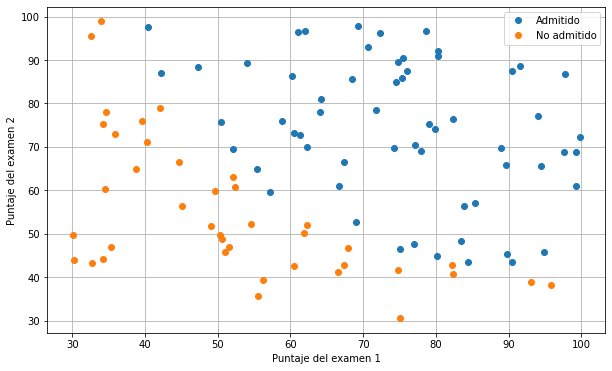

In [108]:
def plotData():
    plt.figure(figsize=(10,6))
    plt.plot(admitido[:,1],admitido[:,2],"o",label='Admitido')
    plt.plot(no_admitido[:,1],no_admitido[:,2],"o",label='No admitido')
    plt.xlabel('Puntaje del examen 1')
    plt.ylabel('Puntaje del examen 2')
    plt.legend()
    plt.grid(True)
    
plotData()

### Implementacion

Funcion hipotesis
$$ h_ \theta (x) =  \frac{\mathrm{1} }{\mathrm{1} + e^{- \theta^Tx} }  $$ 
Funcion de costo
$$  J (\theta) =\frac{1}{m}\sum_{i=1}^{m} [-y^{(i)}log(h_ \theta (x^{(i)})) - (1-y^{(i)})log(1-h_ \theta (x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^{n} \theta^2_j $$

In [109]:
#Funcion Sigmoid
from scipy.special import expit

In [110]:
#Funcion hipotesis (H) y funcion de costo (J)
def sigmoid(parametros, X): 
    return expit(np.dot(X, parametros))

def calcular_costo(parametros, X, y, mylambda = 0.): 
    """
    X matriz de n-filas y m-columnas
    theta es una matriz de m-filas y 1 columna
    y es una matrix with m-filas y una columna
    """
    term1 = np.dot(-np.array(y).T,np.log(sigmoid(parametros, X)))
    term2 = np.dot((1-np.array(y)).T,np.log(1- sigmoid(parametros, X)))
    regterm = (mylambda/2) * np.sum(np.dot(parametros[1:].T, parametros[1:]))
    #term1 y term2 son matrices 1x1, por eso np.sum
    J = float((1./m) * (np.sum(term1 - term2) + regterm))  
    return J

In [111]:
#Iniciar theta matriz de ceros, resultado esperado: J = 0.693
parametros_iniciales = np.zeros((X.shape[1],1))

#Lambda = 0 (sin regularización)
print("El costo inicial es de {}".format(calcular_costo(parametros_iniciales,X,y)))

El costo inicial es de 0.6931471805599453


In [112]:
#La alternativa de OCTAVE "fminunc" es "fmin" de scipy.optimize
#"fmin" no necesita recibir la derivada de la funcion
#Minimiza la funcion (la funcion costo en este caso) con "downhill simplex algorithm".
#http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.fmin.html
from scipy import optimize

def optimizeTheta(mytheta,myX,myy,mylambda=0.):
    """
    Devuelve una lista, el primer termino es theta optimizado para el modelo, y el segundo
    es el costo minimo de la función
    """
    result = optimize.fmin(calcular_costo, x0=mytheta, args=(myX, myy, mylambda), maxiter=400, full_output=True)
    return result[0], result[1]

In [113]:
parametros_optimizados, mincost = optimizeTheta(parametros_iniciales,X,y)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 157
         Function evaluations: 287


In [114]:
#Se vuelve a calular el costo, pero esta vez con el theta optimizado con la funcion "optimizeTheta"
#Se espera un resultado de J = 0.203
print(calcular_costo(parametros_optimizados,X,y))

0.2034977015902151


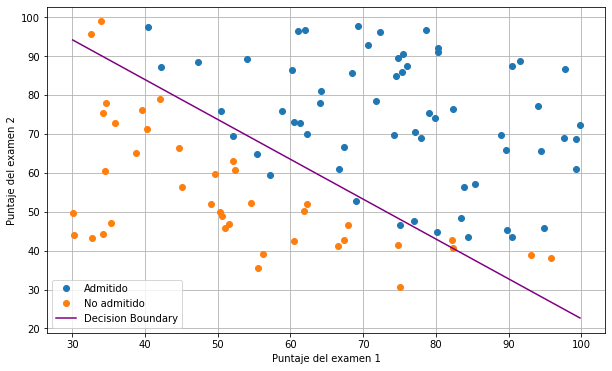

In [115]:
#Se grafican los "decision boundary"
#Los boundary suceden cuando h = 0.5 o cuando theta*X = 0
#theta0 + theta1*x1 + theta2*x2 = 0
#y=mx+b pasando los terminos x2 = (-1/thetheta2)(theta0 + theta1*x1)

boundary_xs = np.array([np.min(X[:,1]), np.max(X[:,1])])
boundary_ys = (-1./parametros_optimizados[2])*(parametros_optimizados[0] + parametros_optimizados[1]*boundary_xs)
plotData()
plt.plot(boundary_xs,boundary_ys,'b-',label='Decision Boundary', color = "purple", linewidth = 1.5)
plt.legend()
plt.show()

In [116]:
#Para un estudiante con puntajes de 45 y 85 deberia tener una probabilidad de aprobar de 0.776
print(sigmoid(parametros_optimizados,np.array([1, 45.,85.])))

0.7762915904112411


In [117]:
def makePrediction(mytheta, myx):
    return sigmoid(mytheta,myx) >= 0.5

#Calcular las predicciones realizadas correctamente
adm_correct = float(np.sum(makePrediction(parametros_optimizados,admitido)))
noAdm_correct = float(np.sum(np.invert(makePrediction(parametros_optimizados,no_admitido))))
tot = len(admitido)+len(no_admitido)
prcnt_correct = float(adm_correct+noAdm_correct)/tot
print ("Porcentaje de datos predecidos correctamente: %.2f" % prcnt_correct )

Porcentaje de datos predecidos correctamente: 0.89
